##  Auxiliary (technical) code

In [1]:
## import all the necessary packages
from pulp import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys as sys
%matplotlib inline

# Mini-project: Pricing Non-Convexities in Power Markets. Out-of-Market Corrections

This source code is provided for grading purposes only, to supplement the report and presentation made within the framework of [Skoltech](www.skoltech.ru) course [Power Markets and Regulations](http://files.skoltech.ru/data/edu/syllabuses/2017/MB06002.pdf) in the Term 4, 2018.
(will be removed upon request)

**Author:** Alexey Bochkarev

The code was tested with the `python3` version `3.6.5`. You have:

In [2]:
sys.version

'3.6.5 (default, Apr  1 2018, 05:46:30) \n[GCC 7.3.0]'


--------------------

# Source code navigation:
## Basic inputs
- [unit commitment](#setup) -- basic problem description
- [case data](#data) -- example (toy) data

## Mechanisms implementation
- [Plain LMP](#PlainLMP) -- base case ("do-nothing" approach)
- [DPA](#DPA) -- Dual Pricing Algorithm
- [IP](#IP) -- Integer programming pricing
- [IP+](#IP+) -- a modified version to keep generators' profits
- [ELMP](#ELMP) -- Extended LMP pricing
- [Vickrey-Clarke-Groves](#VCG) -- unbalanced, classic VCG with Clarke pivot rule

## Results
- [Basic figures](#ResultsNoVCG) -- without VCG mechanism (appeared in the presentation)
- [Additional results](#ResultsVCG) -- with (plain) VCG mechanism (appeared in the report)

## Additional results
Some materials beyond the scope of the report:
- [Balanced VCG](#bVCG) -- a mechanism from the VCG family that financially balances the market and a short discussion

## <a name="setup">Problem setup</a>: dual pricing algorithm in ISO markets
### The unit commitment problem
Following the article, the canonical Unit commitment problem in precense of start-up (SU) costs is:


$ \max{MS} = \sum_{i \in D} b_{i} d_{i} - \sum_{i \in G} (c_i p_i + c_i^{SU} z_i) $

under the constraints:

$ \sum_{i \in D} d_i - \sum_{i \in G} p_i = 0 $

$ p_i^{min} z_i \leq p_i \leq p_i^{max} z_i  \forall i \in G$

$ 0 \leq d_i \leq d_i^{max} \forall i \in D$

$ z_i \in \{0,1\} \forall i \in G$

where:  
- $b_i$ is demand i's marginal value of power consumption
- $d_i$ is i-th consumer demand
- $p_i$ is i-th generator output
- $c_i$ is generator i's marginal generation cost
- $c^{SU}$ is startup cost
- $z_i$ is a binary (1/0) flag indicating whether the i-th generator is ON or not;

## <a name="data">Source data</a>
Please, refer to the report for details

### Generator costs
| Gen | MC, \$,/MWh | SU, \$  | $P_{min}$, MW | $P_{max}$, MW    |
|:----|:-----------:|:-------:|:-------------:|:----------------:|
| A   | 40          | 500     | 0             |     40           |
| B   | 60          | 500     | 10            |     200          |

In [3]:
G = [0,1]; Gnames = ["A","B"];
c = [40,60];
cSU = [500,500];
Pmin = [0,10]; 
Pmax = [40,200];

### Demand function
| Buyer | Value, \$ / MWh | Max demand, MW |
|:------|:---------------:|:--------------:|
| 1     | 100             | 100            |
| 2     |  61             |  30            |

In [4]:
D = [0,1]; Dnames = ["1","2"];
b = [100,61];
Dmax = [100,30];

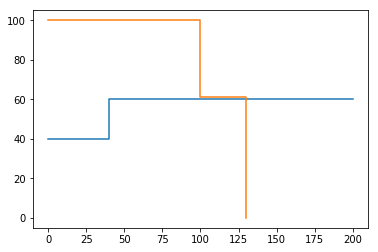

In [5]:
## now let us draw an initial supply-demand plot
plt.plot([0,40,40,200],[40,40,60,60]) ## supply
plt.plot([0,100,100,130,130],[100,100,61,61,0]) ## demand

In [6]:
## set up Pandas dataframe to keep the results
modeling_results = pd.DataFrame(columns=[
        "Unif_Price","GenA_UL","GenB_UL","C1_UL","C2_UL","P_A","P_B","D_1","D_2","Profit_A","Profit_B","Util_1","Util_2","PaidByC","PaidToGen","FinBalance","Costs","UtilityGain"
    ],dtype='float64')

In [7]:
modeling_results ## show the dataframe structure

,Unif_Price,GenA_UL,GenB_UL,C1_UL,C2_UL,P_A,P_B,D_1,D_2,Profit_A,Profit_B,Util_1,Util_2,PaidByC,PaidToGen,FinBalance,Costs,UtilityGain


In [8]:
## auxiliary function to update the `modeling_results` dataframe
## updates total payments information and financial balance
def update_payments(m_results,c,cSU,b):
    ret = m_results;
    ret["PaidByC"]=m_results.eval('Unif_Price*(D_1+D_2)-C1_UL*D_1-C2_UL*D_2');
    ret["PaidToGen"]=m_results.eval('Unif_Price*(P_A+P_B)+GenA_UL*P_A+GenB_UL*P_B');
    ret["FinBalance"]=m_results.eval('PaidByC-PaidToGen');
    ret["Costs"]=m_results["P_A"]*c[0]+cSU[0]*(m_results["P_A"]>0)+\
    ret["P_B"]*c[1]+cSU[1]*(m_results["P_B"]>0);
    ret["UtilityGain"]=m_results["D_1"]*b[0]+m_results["D_2"]*b[1];
    return (ret);

In [9]:
## Calculates out-of-market correction payments to consumers
## given financial imbalance, consumptions, price and values
def calculate_OoMC(FinImbalance, LMP, d_0,d_1,b):
    OMC = []
    OMC_rate = max(-FinImbalance,0) / (d_0 + d_1); ## a rate for Out of Market Correction (per MWh)
    OMC.append(-min(OMC_rate,b[0]-LMP)*d_0); ## min to keep individual rationality (nonnegative profits)
    OMC.append(-min(OMC_rate,b[1]-LMP)*d_1);

    OMC[0] = -min(-FinImbalance + OMC[1], (b[0]-LMP)*d_0); ## if there is not enough money -- we'll borrow from Consumer 1
    
    return (OMC);

## <a name="PlainLMP">Plain LMP</a>: Base case
Now let us calculate the basic case -- without out-of-market corrections (`Plain LMP`)

In [10]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("Unit commitment (Plain LMP)",LpMaximize);

In [11]:
# Create variables; `b` stands for "base" case

db = LpVariable.dicts("Demand",D,0,None, LpContinuous);
pb = LpVariable.dicts("GenOutput",G,0,None, LpContinuous); # note that the lower bound will be ruled by separate constraint
zb = LpVariable.dicts("GenUp",G,0,1,LpBinary);

for i in D:
    db[i].upBound = Dmax[i];

for i in G:
    pb[i].upBound = Pmax[i];
    
# Indicate objective function
prob += lpSum((b[i]*db[i]) for i in D) - lpSum((c[i]*pb[i]+cSU[i]*zb[i]) for i in G);

# Add constraints
DemandConstraint = lpSum(db[i] for i in D) == lpSum(pb[i] for i in G);
prob += DemandConstraint, "DemandSatisfied"

for i in G:
    prob += Pmin[i]*zb[i] <= pb[i];
    prob += pb[i] <= Pmax[i]*zb[i];

In [12]:
# Find optimal solution
stime = time.time();

prob.solve();

etime = time.time();
secs = etime - stime;

m, s = divmod(secs, 60);
h, m = divmod(m, 60)

print ("Finished after %d:%02d:%02d" % (h, m, s))
print("Status:", LpStatus[prob.status])
print ("Objective value:  %s" % value(prob.objective))

Finished after 0:00:00
Status: Optimal
Objective value:  3830.0


In [13]:
# Now calculate the uniform price (LMP)
LMP = DemandConstraint.pi; ## shadow price
print ("lambda = " + str(LMP))

lambda = 60.0


In [14]:
modeling_results.loc["Plain LMP"] = [LMP, 0,0,0,0,pb[0].varValue,pb[1].varValue,db[0].varValue,db[1].varValue,
    pb[0].varValue*(LMP - c[0]) - cSU[0]*zb[0].varValue,
    pb[1].varValue*(LMP - c[1]) - cSU[1]*zb[1].varValue,
    db[0].varValue*(b[0] - LMP),
    db[1].varValue*(b[1] - LMP),
    'NaN','NaN','NaN','NaN','NaN'];
modeling_results = update_payments(modeling_results, c, cSU, b);
modeling_results.round(1)

,Unif_Price,GenA_UL,GenB_UL,C1_UL,C2_UL,P_A,P_B,D_1,D_2,Profit_A,Profit_B,Util_1,Util_2,PaidByC,PaidToGen,FinBalance,Costs,UtilityGain
Plain LMP,60.0,0.0,0.0,0.0,0.0,40.0,90.0,100.0,30.0,300.0,-500.0,4000.0,30.0,7800.0,7800.0,0.0,8000.0,11830.0


## Out-of-market corrections
### <a name="DPA">DPA</a> - Dual Pricing Algorithm
We fix solution of the previous problem (denoting the corresponding values with stars -- \*). And try to find necessary payments between market players. We further denote 
payments by $u$'s:
- amount $u^{pd}$ is paid TO the consumer, amount $u^{cd}$ is paid BY the consumer (to the market commercial operator);
- amount $u^{p}$ is paid TO the generator, amount $u^c$ is paid BY the generator

The objective now is to minimize amount of payments:

$ \min \sum_{i \in D} d^*_i u^{pd}_i + \sum_{i \in G} p^* u^p_i $

under the constraints:

$ \sum_{i \in D} d_i^* (u_i^{pd} - u_i^{cd}) + \sum_{i \in G^+} p_i^* (u^p_i - u^c_i) = 0$ -- balance of payments

$ \Psi_i = d^*_i (b_i - \lambda^{DPA} + u^{pd}_i - u^{cd}_i) \quad \forall i \in D^+$ -- "profits" of consumers

$ \Pi_i = p_i^* (\lambda^{DPA} - c_i + u_i^p - u_i^c) - c_i^{SU} \quad \forall i \in G^+$ -- generators' profits

$ \Psi_i \geq 0 \quad \forall i \in D^+$ -- incentive compatibility (consumers)

$ \Pi_i \geq 0 \quad \forall i \in G^+$ -- incentive compatibility (generators)

And all payments are nonnegative:

$ u_i^p, u_i^c, u_i^{pd}, u_i^{cd} \geq 0 $

Now let us formulate and solve the corresponding problem:

In [15]:
probDPA = LpProblem("DPA",LpMinimize);

In [16]:
# Create variables
u_pd = LpVariable.dicts("PaidToConsumer",D,0,None, LpContinuous);
u_p = LpVariable.dicts("PaidToGenerator",G,0,None, LpContinuous);

u_cd = LpVariable.dicts("PaidByConsumer",D,0,None, LpContinuous);
u_c = LpVariable.dicts("PaidByGenerator",G,0,None, LpContinuous);

Psi = LpVariable.dicts("ConsumerUtility",D,None,None, LpContinuous);
Pi = LpVariable.dicts("GeneratorProfits",G,None,None, LpContinuous);

LMP_DPA = LpVariable("LMP_DPA");

In [17]:
# Objective
probDPA += lpSum(db[i].varValue*u_pd[i] for i in D) + lpSum(pb[i].varValue*u_p[i] for i in G)

In [18]:
# constraints
probDPA += lpSum(db[i].varValue *(u_pd[i] - u_cd[i]) for i in D) + lpSum( pb[i].varValue*(u_p[i] - u_c[i]) for i in G) == 0
for i in D:
    probDPA += Psi[i] == db[i].varValue*(b[i] - LMP_DPA + u_pd[i]-u_cd[i]);
    probDPA += Psi[i] >= 0;

for i in G:
    probDPA += Pi[i] == pb[i].varValue*(LMP_DPA - c[i] + u_p[i] - u_c[i]) - cSU[i]*zb[i].varValue;
    probDPA += Pi[i] >=0;



In [19]:
# Find optimal solution
stime = time.time();

probDPA.solve();

etime = time.time();
secs = etime - stime;

m, s = divmod(secs, 60);
h, m = divmod(m, 60)

print ("Finished after %d:%02d:%02d" % (h, m, s))
print ("Status:", LpStatus[prob.status])

Finished after 0:00:00
Status: Optimal


In [20]:
## save results to the dataframe
modeling_results.loc["DPA"] = [LMP_DPA.varValue,
                                u_p[0].varValue-u_c[0].varValue,
                                u_p[1].varValue-u_c[1].varValue,
                                u_pd[0].varValue-u_cd[0].varValue,
                                u_pd[1].varValue-u_cd[1].varValue,
                               pb[0].varValue,
                               pb[1].varValue,
                               db[0].varValue,
                               db[1].varValue,
                               Pi[0].varValue,Pi[1].varValue,Psi[0].varValue,Psi[1].varValue,
                               'NaN','NaN','NaN','NaN','NaN'
                              ]
modeling_results = update_payments(modeling_results,c,cSU,b);
modeling_results.round(1)

,Unif_Price,GenA_UL,GenB_UL,C1_UL,C2_UL,P_A,P_B,D_1,D_2,Profit_A,Profit_B,Util_1,Util_2,PaidByC,PaidToGen,FinBalance,Costs,UtilityGain
Plain LMP,60.0,0.0,0.0,0.0,0.0,40.0,90.0,100.0,30.0,300.0,-500.0,4000.0,30.0,7800.0,7800.0,0.0,8000.0,11830.0
DPA,65.6,0.0,0.0,-1.4,4.6,40.0,90.0,100.0,30.0,522.2,0.0,3307.8,0.0,8522.2,8522.2,0.0,8000.0,11830.0


## <a name="IP">IP</a>: Integer Programming pricing
The logic is as follows: 
- Solve initial MIP; 
- fix integral variables at optimal levels and obtain LP;
- solve LP to obtain:
    - **Price** = Shadow price for balance constraint
    - **Uplift** = Shadow price for “int.” constraint (if q>0)

In [21]:
# Create the 'prob' variable to contain the problem data
probIP = LpProblem("Unit commitment - initial MIP",LpMaximize);
# Create variables
d = LpVariable.dicts("Demand",D,0,None, LpContinuous);
p = LpVariable.dicts("GenOutput",G,0,None, LpContinuous); # note that the lower bound will be ruled by a separate constraint
z = LpVariable.dicts("GenUp",G,0,1,LpBinary);

for i in D:
    d[i].upBound = Dmax[i];

# Indicate objective function
probIP += lpSum((b[i]*d[i]) for i in D) - lpSum((c[i]*p[i]+cSU[i]*z[i]) for i in G);
        
# Add constraints
DemandConstraint = lpSum(d[i] for i in D) == lpSum(p[i] for i in G);
probIP += DemandConstraint, "DemandSatisfied"

for i in G:
    probIP += Pmin[i]*z[i] <= p[i];
    probIP += p[i] <= Pmax[i]*z[i];
        
# Find optimal solution
stime = time.time();

probIP.solve();

etime = time.time();
secs = etime - stime;

m, s = divmod(secs, 60);
h, m = divmod(m, 60)

print ("Finished after %d:%02d:%02d" % (h, m, s))
print("Status:", LpStatus[probIP.status])

Finished after 0:00:00
Status: Optimal


In [22]:
## Now let us relax the problem to LP
## fixing integer constraints
    
zOpt = [z[i].varValue for i in G];

probR = LpProblem("Unit commitment - relaxed LP",LpMaximize);
# Create variables
d1 = LpVariable.dicts("Demand",D,0,None, LpContinuous);
p1 = LpVariable.dicts("GenOutput",G,0,None, LpContinuous); # note that the lower bound will be ruled by separate constraint
z1 = LpVariable.dicts("GenUp",G,0,None,LpContinuous); ## relaxed integrality constraint

for i in D:
    d1[i].upBound = Dmax[i];

# Indicate objective function
probR += lpSum((b[i]*d1[i]) for i in D) - lpSum((c[i]*p1[i]+cSU[i]*z1[i]) for i in G);
        
# Add constraints
DemandConstraint = lpSum(d1[i] for i in D) == lpSum(p1[i] for i in G);
probR += DemandConstraint, "DemandSatisfied"

for i in G:
    probR += Pmin[i]*z1[i] <= p1[i];
    probR += p1[i] <= Pmax[i]*z1[i];
    

zConstraintA = z1[0] == zOpt[0];
zConstraintB = z1[1] == zOpt[1];

probR += zConstraintA, "z-constraint for Gen A"
probR += zConstraintB, "z-constraint for Gen B"
       
# Find optimal solution
stime = time.time();

probR.solve()

etime = time.time();
secs = etime - stime;

m, s = divmod(secs, 60);
h, m = divmod(m, 60)

print ("Finished after %d:%02d:%02d" % (h, m, s))
print("Status:", LpStatus[prob.status])

LMP = DemandConstraint.pi;

Finished after 0:00:00
Status: Optimal


In [23]:
FinImbalance = zConstraintA.pi*z1[0].varValue+zConstraintB.pi*z1[1].varValue
FinImbalance

-200.0

In [24]:
OMC = calculate_OoMC(FinImbalance, LMP, d1[0].varValue, d1[1].varValue,b);
OMC

[-170.0, -30.0]

In [25]:
modeling_results.loc["IP"] = [LMP, 
        -z1[0].varValue * zConstraintA.pi / p1[0].varValue,
        -z1[1].varValue * zConstraintB.pi / p1[1].varValue,
        OMC[0]/d1[0].varValue, OMC[1]/d1[1].varValue,
        p1[0].varValue, p1[1].varValue,
        d1[0].varValue, d1[1].varValue,
         
        p1[0].varValue*(LMP - c[0]) - cSU[0]*z1[0].varValue-z1[0].varValue * zConstraintA.pi,
        p1[1].varValue*(LMP - c[1]) - cSU[1]*z1[1].varValue-z1[1].varValue * zConstraintB.pi,
        d1[0].varValue*(b[0] - LMP)+OMC[0],
        d1[1].varValue*(b[1] - LMP)+OMC[1],
        'NaN','NaN','NaN','NaN','NaN'
    ]

modeling_results = update_payments(modeling_results,c,cSU,b);
modeling_results.round(1)

,Unif_Price,GenA_UL,GenB_UL,C1_UL,C2_UL,P_A,P_B,D_1,D_2,Profit_A,Profit_B,Util_1,Util_2,PaidByC,PaidToGen,FinBalance,Costs,UtilityGain
Plain LMP,60.0,0.0,0.0,0.0,0.0,40.0,90.0,100.0,30.0,300.0,-500.0,4000.0,30.0,7800.0,7800.0,0.0,8000.0,11830.0
DPA,65.6,0.0,0.0,-1.4,4.6,40.0,90.0,100.0,30.0,522.2,0.0,3307.8,0.0,8522.2,8522.2,0.0,8000.0,11830.0
IP,60.0,-7.5,5.6,-1.7,-1.0,40.0,90.0,100.0,30.0,0.0,0.0,3830.0,0.0,8000.0,8000.0,0.0,8000.0,11830.0


## <a name="IP+">IP+</a>: keeping generators' profits

In [26]:
## we do not need to recalculate optimization problem
## only financial imbalance and settlement
FinImbalance = -(max(-z1[0].varValue * zConstraintA.pi,0)+max(-z1[1].varValue * zConstraintB.pi,0))
FinImbalance

-500.0

In [27]:
OMC = calculate_OoMC(FinImbalance, LMP, d1[0].varValue, d1[1].varValue,b);
OMC

[-470.0, -30.0]

In [28]:
## now let us reconstruct IP+ -- keeping only positive uplifts to generators

modeling_results.loc["IP+"] = [LMP, 
        max(-z1[0].varValue * zConstraintA.pi / p1[0].varValue,0),
        max(-z1[1].varValue * zConstraintB.pi / p1[1].varValue,0),
        OMC[0]/d1[0].varValue, OMC[1]/d1[1].varValue,
        p1[0].varValue, p1[1].varValue,
        d1[0].varValue, d1[1].varValue,
         
        p1[0].varValue*(LMP - c[0]) - cSU[0]*z1[0].varValue+max(-z1[0].varValue * zConstraintA.pi,0),
        p1[1].varValue*(LMP - c[1]) - cSU[1]*z1[1].varValue+max(-z1[1].varValue * zConstraintB.pi,0),
        d1[0].varValue*(b[0] - LMP)+OMC[0],
        d1[1].varValue*(b[1] - LMP)+OMC[1],
        'NaN','NaN','NaN','NaN','NaN'
    ]

modeling_results = update_payments(modeling_results,c,cSU,b);
modeling_results.round(1)

,Unif_Price,GenA_UL,GenB_UL,C1_UL,C2_UL,P_A,P_B,D_1,D_2,Profit_A,Profit_B,Util_1,Util_2,PaidByC,PaidToGen,FinBalance,Costs,UtilityGain
Plain LMP,60.0,0.0,0.0,0.0,0.0,40.0,90.0,100.0,30.0,300.0,-500.0,4000.0,30.0,7800.0,7800.0,0.0,8000.0,11830.0
DPA,65.6,0.0,0.0,-1.4,4.6,40.0,90.0,100.0,30.0,522.2,0.0,3307.8,0.0,8522.2,8522.2,0.0,8000.0,11830.0
IP,60.0,-7.5,5.6,-1.7,-1.0,40.0,90.0,100.0,30.0,0.0,0.0,3830.0,0.0,8000.0,8000.0,0.0,8000.0,11830.0
IP+,60.0,0.0,5.6,-4.7,-1.0,40.0,90.0,100.0,30.0,300.0,0.0,3530.0,0.0,8300.0,8300.0,0.0,8000.0,11830.0


## <a name="ELMP">ELMP</a>: Extended LMP
- relax integrality constraint -- formulate new LP
- solve new LP; uniform **price** = shadow price of balance constraint. **Uplifts** -- minimum payments to ensure incentive-compatibility (paid conditional on the committing according to the schedule)

In [29]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("Unit commitment - initial MIP",LpMaximize);
# Create variables
d = LpVariable.dicts("Demand",D,0,None, LpContinuous);
p = LpVariable.dicts("GenOutput",G,0,None, LpContinuous); # note that the lower bound will be ruled by separate constraint
z = LpVariable.dicts("GenUp",G,0,1,LpContinuous);

for i in D:
    d[i].upBound = Dmax[i];
        
# Indicate objective function
prob += lpSum((b[i]*d[i]) for i in D) - lpSum((c[i]*p[i]+cSU[i]*z[i]) for i in G);
        
# Add constraints
DemandConstraint = lpSum(d[i] for i in D) == lpSum(p[i] for i in G);
prob += DemandConstraint, "DemandSatisfied"

for i in G:
    prob += Pmin[i]*z[i] <= p[i];
    prob += p[i] <= Pmax[i]*z[i];
        
# Find optimal solution
stime = time.time();

prob.solve();

etime = time.time();
secs = etime - stime;

m, s = divmod(secs, 60);
h, m = divmod(m, 60)

print ("Finished after %d:%02d:%02d" % (h, m, s))
print("Status:", LpStatus[prob.status])

Finished after 0:00:00
Status: Optimal


In [30]:
LMP=DemandConstraint.pi ## this is the new price (ELMP)
LMP

62.5

In [31]:
## out-of-market payments *to* generators
LOC_G = []
LOC_G.append(max(-((LMP-c[0])*p1[0].varValue-cSU[0]*z1[0].varValue),0))
LOC_G.append(max(-((LMP-c[1])*p1[1].varValue-cSU[1]*z1[1].varValue),0))
LOC_G

[0, 275.0]

In [32]:
## out-of-market payments *to* consumers
LOC_C = []
LOC_C.append(max(-(b[0]-LMP)*d1[0].varValue,0))
LOC_C.append(max(-(b[1]-LMP)*d1[1].varValue,0))
LOC_C

[0, 45.0]

In [33]:
FinImbalance = -np.sum(LOC_G)
FinImbalance

-275.0

In [34]:
## note that we have a slightly different setting due to LOC payments to consumers
OMC = []
OMC_rate = max(-FinImbalance,0) / (d1[0].varValue + d1[1].varValue); ## for Out of Market Correction
OMC.append(max(-min(OMC_rate*d1[0].varValue,(b[0]-LMP)*d1[0].varValue),LOC_C[0]));
OMC.append(max(-min(OMC_rate*d1[1].varValue,(b[1]-LMP)*d1[1].varValue),LOC_C[1]));

OMC[0] = -min(-FinImbalance + OMC[1], (b[0]-LMP)*d1[0].varValue);
OMC

[-320.0, 45.0]

In [35]:
modeling_results.loc["ELMP"] = [LMP, 
        LOC_G[0]/p1[0].varValue, LOC_G[1]/p1[1].varValue,
        OMC[0]/d1[0].varValue, OMC[1]/d1[1].varValue,
        p1[0].varValue, p1[1].varValue,
        d1[0].varValue, d1[1].varValue,
        p1[0].varValue*(LMP - c[0])-cSU[0]*(p1[0].varValue>0)+LOC_G[0],
        p1[1].varValue*(LMP - c[1])-cSU[1]*(p1[1].varValue>0)+LOC_G[1],
        d1[0].varValue*(b[0] - LMP)+OMC[0],
        d1[1].varValue*(b[1] - LMP)+OMC[1],
        'NaN','NaN','NaN', 'NaN', 'NaN'
    ]

modeling_results = update_payments(modeling_results,c,cSU,b);
modeling_results.round(1)

,Unif_Price,GenA_UL,GenB_UL,C1_UL,C2_UL,P_A,P_B,D_1,D_2,Profit_A,Profit_B,Util_1,Util_2,PaidByC,PaidToGen,FinBalance,Costs,UtilityGain
Plain LMP,60.0,0.0,0.0,0.0,0.0,40.0,90.0,100.0,30.0,300.0,-500.0,4000.0,30.0,7800.0,7800.0,0.0,8000.0,11830.0
DPA,65.6,0.0,0.0,-1.4,4.6,40.0,90.0,100.0,30.0,522.2,0.0,3307.8,0.0,8522.2,8522.2,0.0,8000.0,11830.0
IP,60.0,-7.5,5.6,-1.7,-1.0,40.0,90.0,100.0,30.0,0.0,0.0,3830.0,0.0,8000.0,8000.0,0.0,8000.0,11830.0
IP+,60.0,0.0,5.6,-4.7,-1.0,40.0,90.0,100.0,30.0,300.0,0.0,3530.0,0.0,8300.0,8300.0,0.0,8000.0,11830.0
ELMP,62.5,0.0,3.1,-3.2,1.5,40.0,90.0,100.0,30.0,400.0,0.0,3430.0,0.0,8400.0,8400.0,0.0,8000.0,11830.0


## <a name="ResultsNoVCG">Figures</a>: basic results
For the moment -- without the VCG mechanism

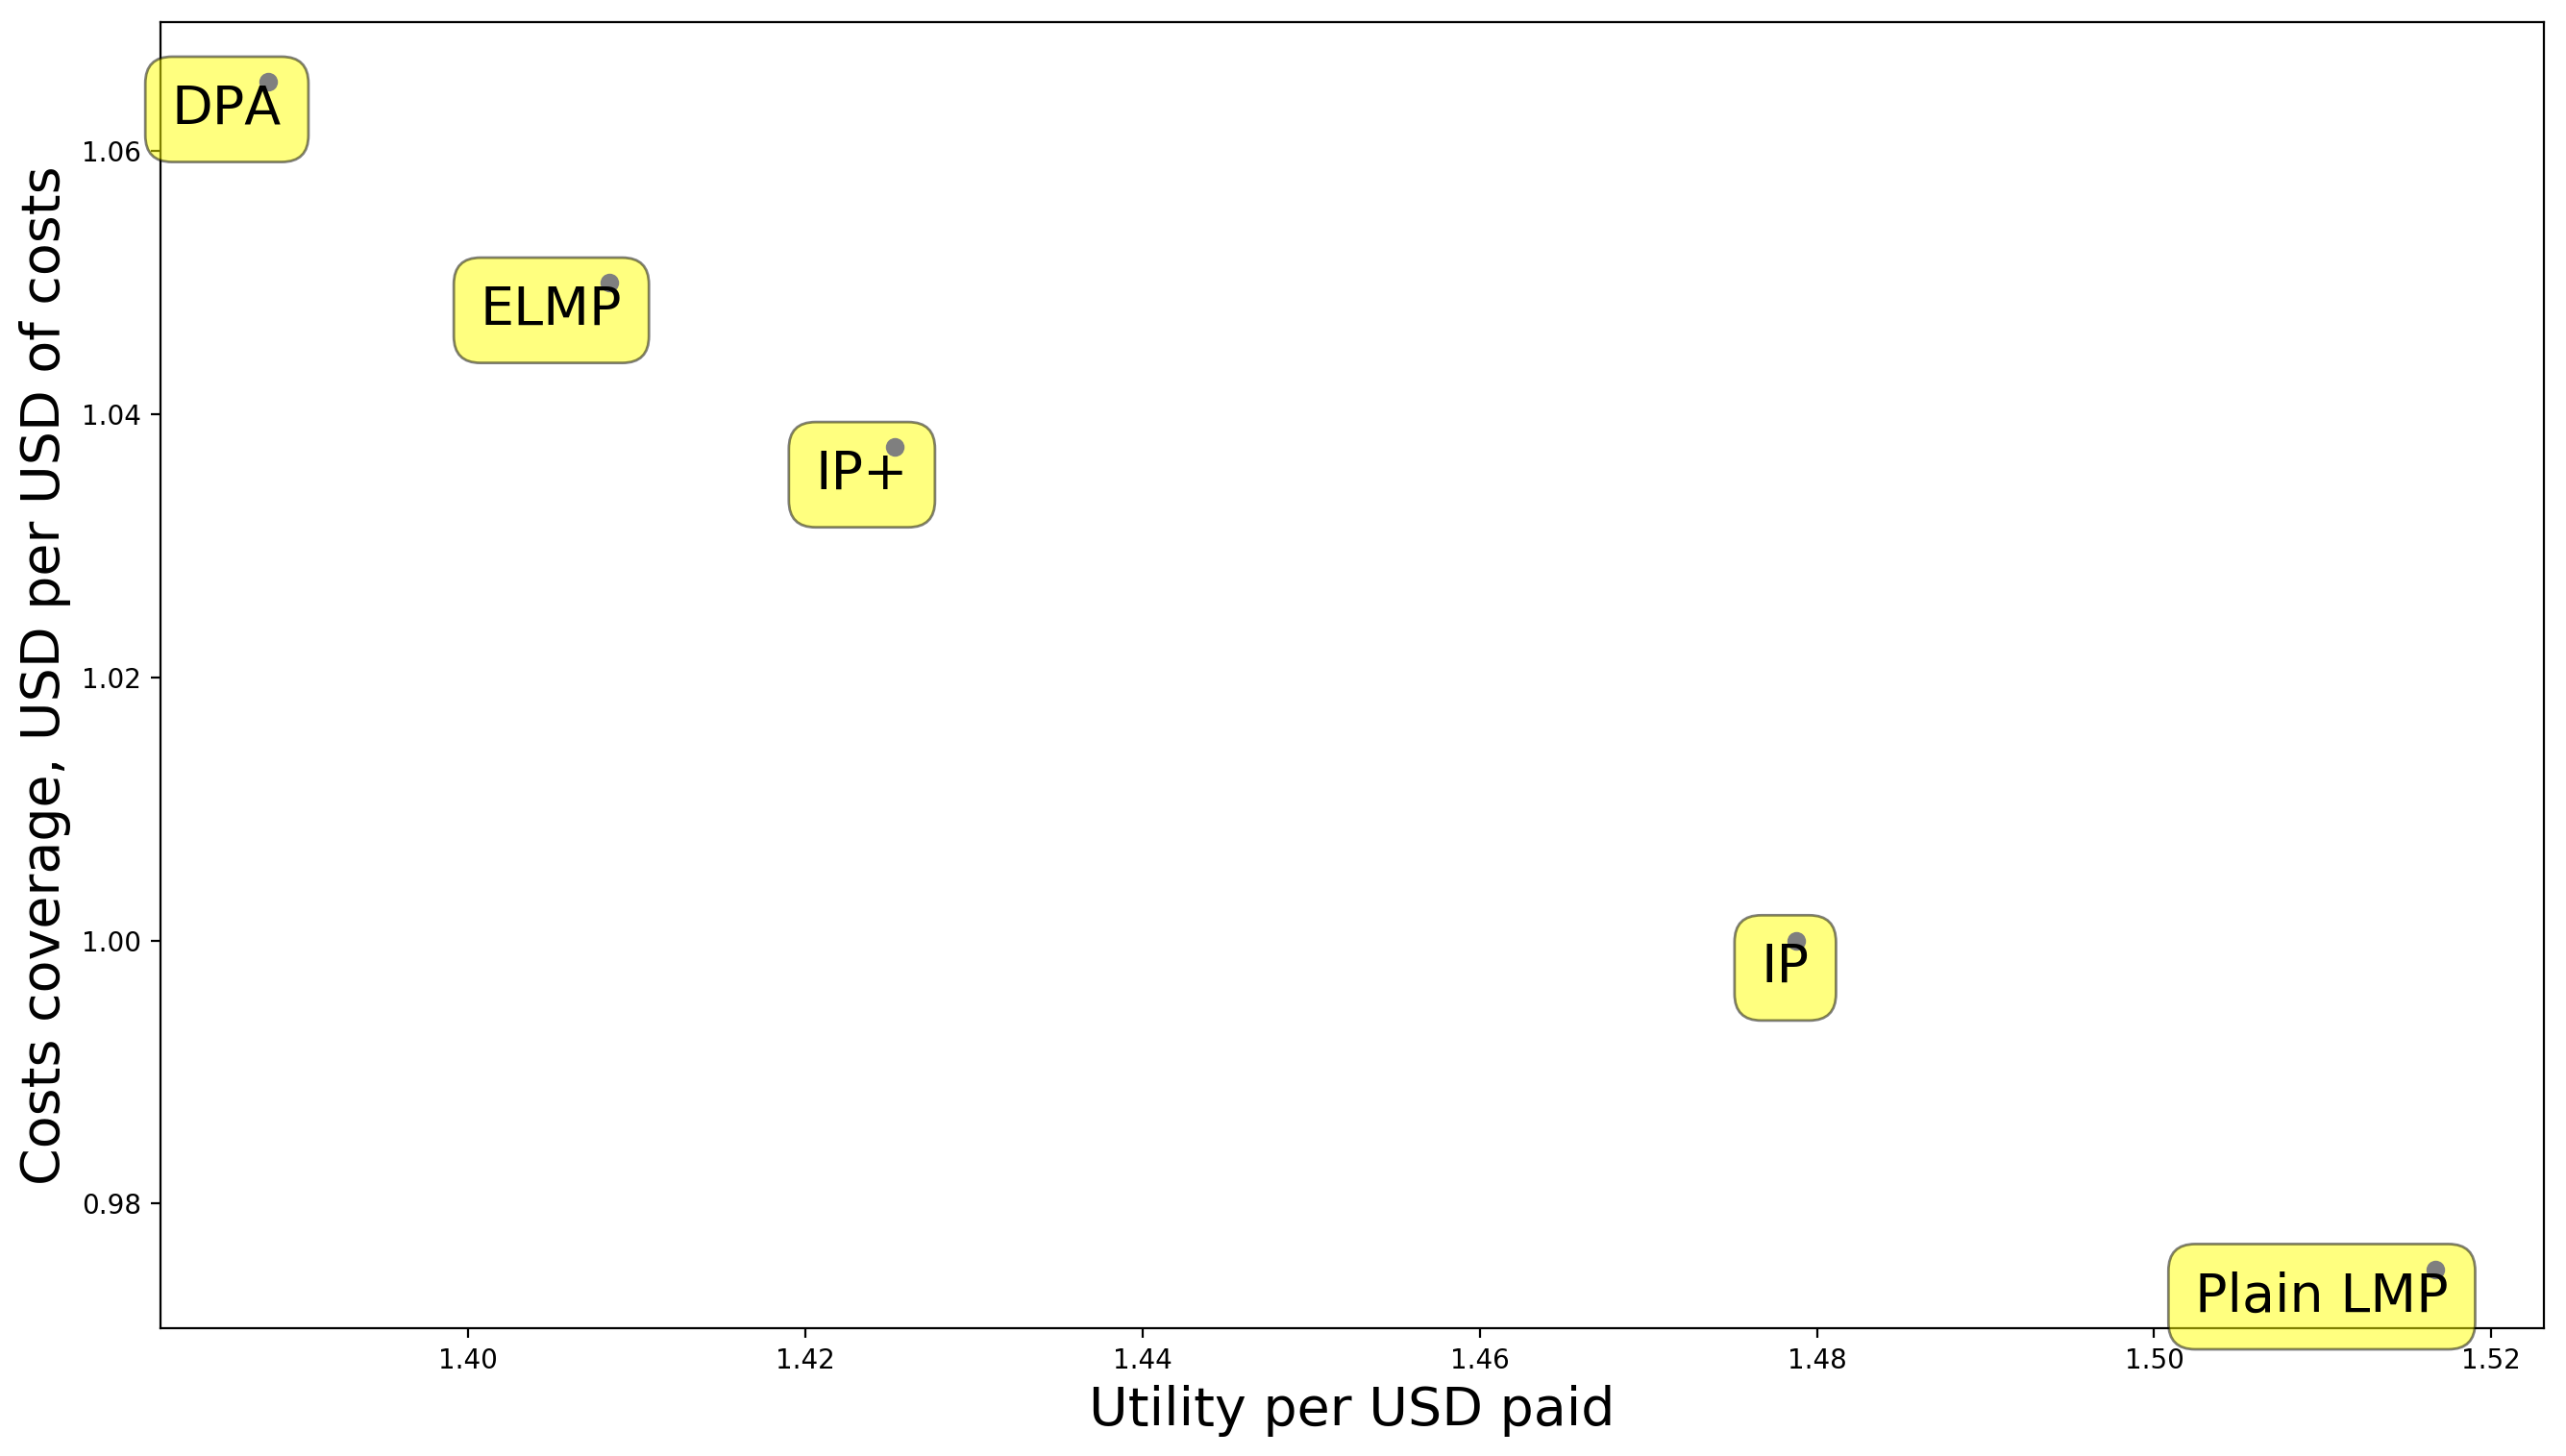

In [36]:
## Figure 3a in the report

pts_x=modeling_results.UtilityGain/modeling_results.PaidByC;
pts_y=modeling_results.PaidToGen/modeling_results.Costs;

plt.figure(figsize=(16, 9), dpi= 200, facecolor='w', edgecolor='k')

for i in range(len(pts_x)):
    plt.annotate(
        modeling_results.index[i],
        xy=(pts_x[i],pts_y[i]),
        xytext=(5, -20),
        size=20,
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5)
    )

plt.plot(pts_x,pts_y,'bo')

plt.xlabel("Utility per USD paid",size=20);
plt.ylabel("Costs coverage, USD per USD of costs",size=20);


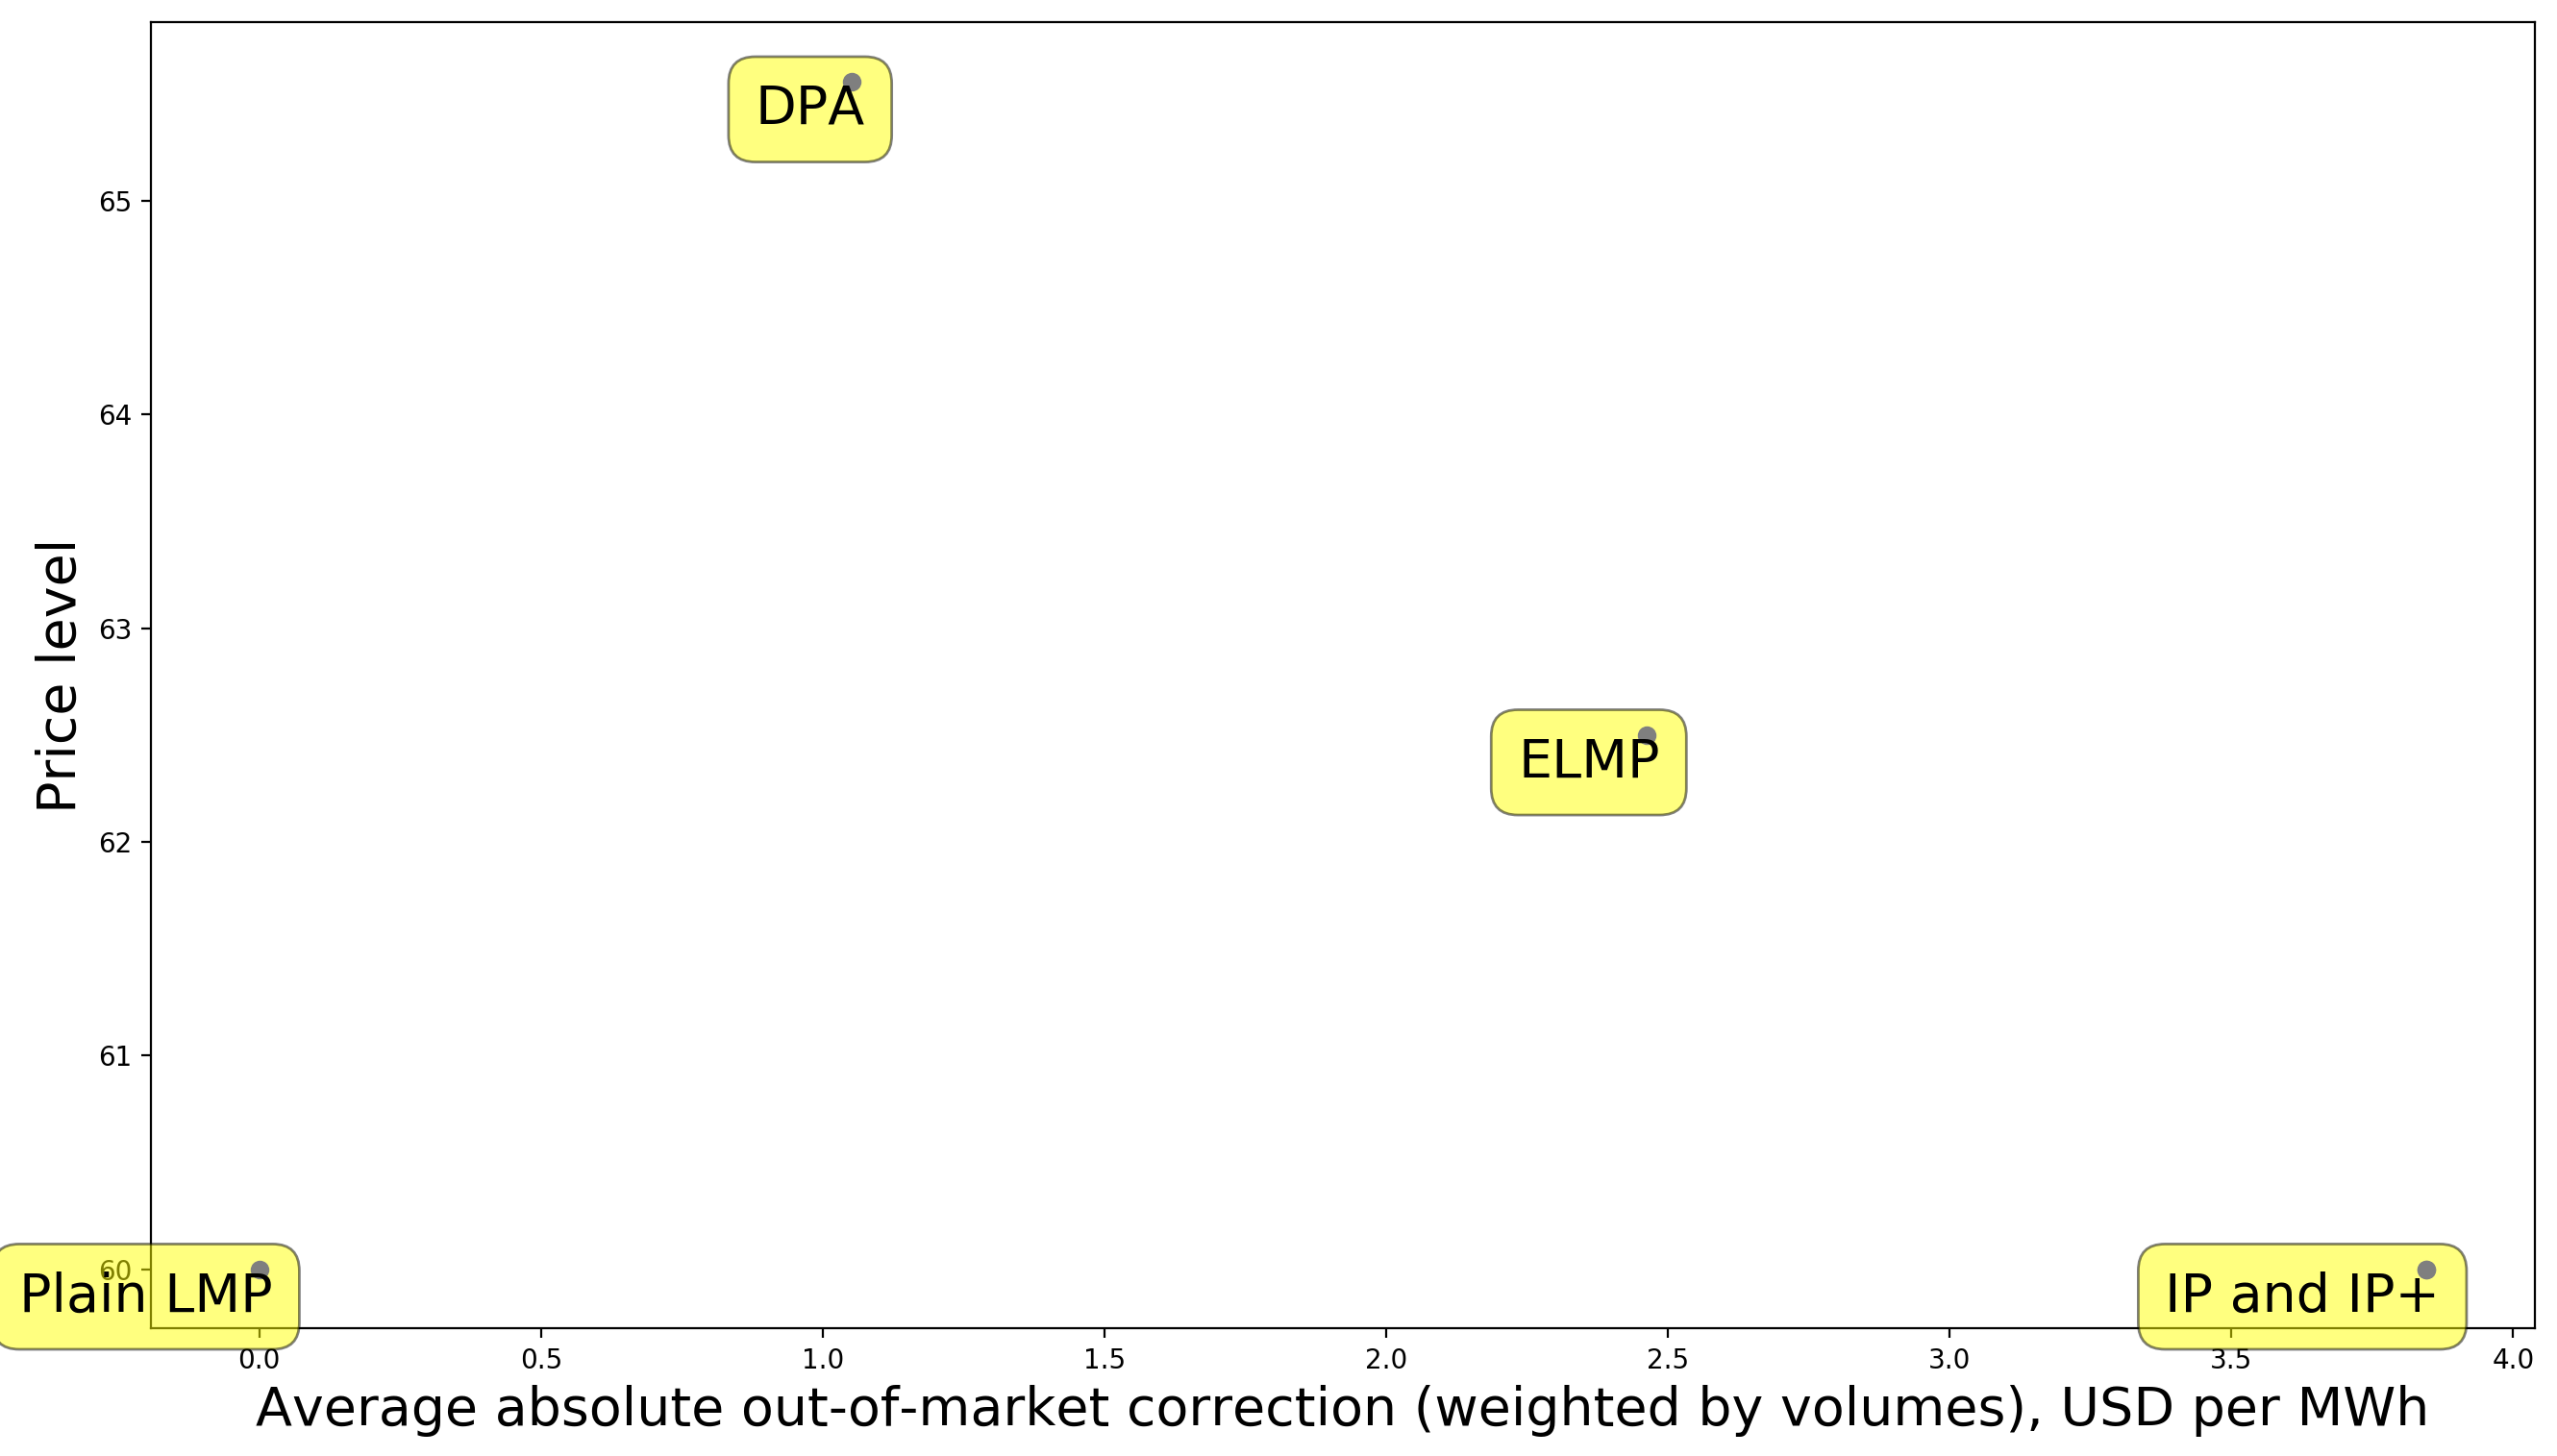

In [37]:
# Figure 2 in the report

pts_y=modeling_results.Unif_Price
pts_x=modeling_results.eval('abs(GenA_UL*P_A)+abs(GenB_UL*P_B)+abs(C1_UL*D_1)+abs(C2_UL*D_2)') / modeling_results.eval('P_A+P_B+D_1+D_2');

plt.figure(figsize=(16, 9), dpi= 200, facecolor='w', edgecolor='k')


labels=[modeling_results.index[i] for i in range(len(modeling_results.index))]
labels = ["IP and IP+" if x=="IP" else x for x in labels]
labels = ["" if x=="IP+" else x for x in labels]

for i in range(len(pts_x)):
    plt.annotate(
        labels[i],
        xy=(pts_x[i],pts_y[i]),
        xytext=(5, -20),
        size=20,
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5)
    )

plt.plot(pts_x,pts_y,'bo')

plt.xlabel("Average absolute out-of-market correction (weighted by volumes), USD per MWh",size=20);
plt.ylabel("Price level",size=20);


## A <a name="VCG">VCG</a> mechanism

Let us calculate payments for each agent as their externality to others (generators will have positive payments, consumers -- negatives);

In [38]:
####################################################################################
## Calculate VCG-payments 
## ===== TO consumers (negative = payments FROM consumers) =====

## notice that we use the optimal point calculated in the Base case (=Plain LMP=)

## variables for VCG-payments calculation
others_surpluses = [];
max_o_surpluses = [];

probs = []; ## problems list (one entry for one consumer)

## variables
ds =[];
ps = [];
zs =[];

Pvcg_consumers = []; ## list of payments TO players (consumers)

for i in D:
    
    ## set variables
    D_mi = [D[j] for j in D if j!=i];
    
    Dmax_mi = dict(zip([j for j in D if j!=i], [Dmax[j] for j in D if j!=i])); # now we have to use dict not to mess with indices
    
    ## other players' surplus
    others_surpluses.append(np.sum([(b[j]*db[j].varValue) for j in D_mi]) - np.sum([c[j]*pb[j].varValue + zb[j].varValue*cSU[j] for j in G]));          
    
    ## the solution without the player
    probs.append(LpProblem("Unit commitment w/o consumer "+str(i),LpMaximize));
    ds.append(LpVariable.dicts("Demand",D_mi,0,None, LpContinuous));
    ps.append(LpVariable.dicts("GenOutput",G,0,None, LpContinuous));
    zs.append(LpVariable.dicts("GenUp",G,0,1,LpBinary));

    for j in D_mi:
        ds[i][j].upBound = Dmax_mi[j];
        
    ## set the objective
    probs[i] += lpSum((b[j]*ds[i][j]) for j in D_mi) - lpSum((c[j]*ps[i][j]+cSU[j]*zs[i][j]) for j in G);
    
    ## add constraints
    probs[i] += lpSum(ds[i][j] for j in D_mi) == lpSum(ps[i][j] for j in G);

    for j in G:
        probs[i] += Pmin[j]*zs[i][j] <= ps[i][j];
        probs[i] += ps[i][j] <= Pmax[j]*zs[i][j];
        
    probs[i].solve();
    
    print("Status: "+LpStatus[probs[i].status]);
    
    max_o_surpluses.append(np.sum([(b[j]*ds[i][j].varValue) for j in D_mi]) - np.sum([c[j]*ps[i][j].varValue + zs[i][j].varValue*cSU[j] for j in G]))
    
    Pvcg_consumers.append(others_surpluses[i] - max_o_surpluses[i]);
    
    print ("VCG Payment for consumer ",Dnames[i],": ", Pvcg_consumers[i],"\n")
    

Status: Optimal
VCG Payment for consumer  1 :  -6300.0 

Status: Optimal
VCG Payment for consumer  2 :  -1800.0 



In [39]:
####################################################################################
## Calculate VCG-payments 
## ===== TO generators (positive) =====

## variables for VCG-payments calculation
gen_others_surpluses = [];
gen_max_o_surpluses = [];

## variables
gen_ds =[];
gen_ps = [];
gen_zs =[];

Pvcg_gen = []; ## list of payments TO players (consumers)

for i in G:
    
    ## set variables
    G_mi = [G[j] for j in G if j!=i];
    
    ## other players' surplus
    gen_others_surpluses.append(np.sum([(b[j]*db[j].varValue) for j in D]) - np.sum([c[j]*pb[j].varValue + zb[j].varValue*cSU[j] for j in G_mi]));          
    
    ## the solution without the player
    gen_prob = LpProblem("Unit commitment w/o generator "+Gnames[i],LpMaximize);
    gen_ds = LpVariable.dicts("Demand",D,0,None, LpContinuous);
    gen_ps = LpVariable.dicts("GenOutput",G_mi,0,None, LpContinuous);
    gen_zs = LpVariable.dicts("GenUp",G_mi,0,1,LpBinary);

    for j in D:
        gen_ds[j].upBound = Dmax[j];
        
    ## set the objective
    gen_prob += lpSum((b[j]*gen_ds[j]) for j in D) - lpSum((c[j]*gen_ps[j]+cSU[j]*gen_zs[j]) for j in G_mi);
    
    ## add constraints
    gen_prob += lpSum(gen_ds[j] for j in D) == lpSum(gen_ps[j] for j in G_mi);

    for j in G_mi:
        gen_prob += Pmin[j] * gen_zs[j] - gen_ps[j] <= 0.0
        gen_prob += gen_ps[j] - Pmax[j] * gen_zs[j] <= 0.0

    gen_prob.solve(COIN_CMD());
    
    print ("Status: ", LpStatus[gen_prob.status]);
    
    gen_max_o_surpluses.append(np.sum([(b[j]*gen_ds[j].varValue) for j in D]) - np.sum([c[j]*gen_ps[j].varValue + gen_zs[j].varValue*cSU[j] for j in G_mi]))
    
    Pvcg_gen.append(gen_others_surpluses[i] - gen_max_o_surpluses[i]); ### the VCG payment
    
    print ("VCG Payment for generator ",Gnames[i],": ", Pvcg_gen[i]);
    print
    

Status:  Optimal
VCG Payment for generator  A :  2400.0
Status:  Optimal
VCG Payment for generator  B :  7830.0


In [40]:
## Calculating total payments for a plain VCG mechanism

UtilityGain_VCG = b[0]*db[0].varValue + b[1]*db[1].varValue
PaidByC_VCG = -np.sum(Pvcg_consumers);

PaidToGen_VCG = --np.sum(Pvcg_gen);
Costs_VCG = c[0]*pb[0].varValue+cSU[0]*(pb[0].varValue>0) + c[1]*pb[1].varValue+cSU[1]*(pb[1].varValue>0)

## <a name="ResultsVCG">Figures</a>: additional results with VCG

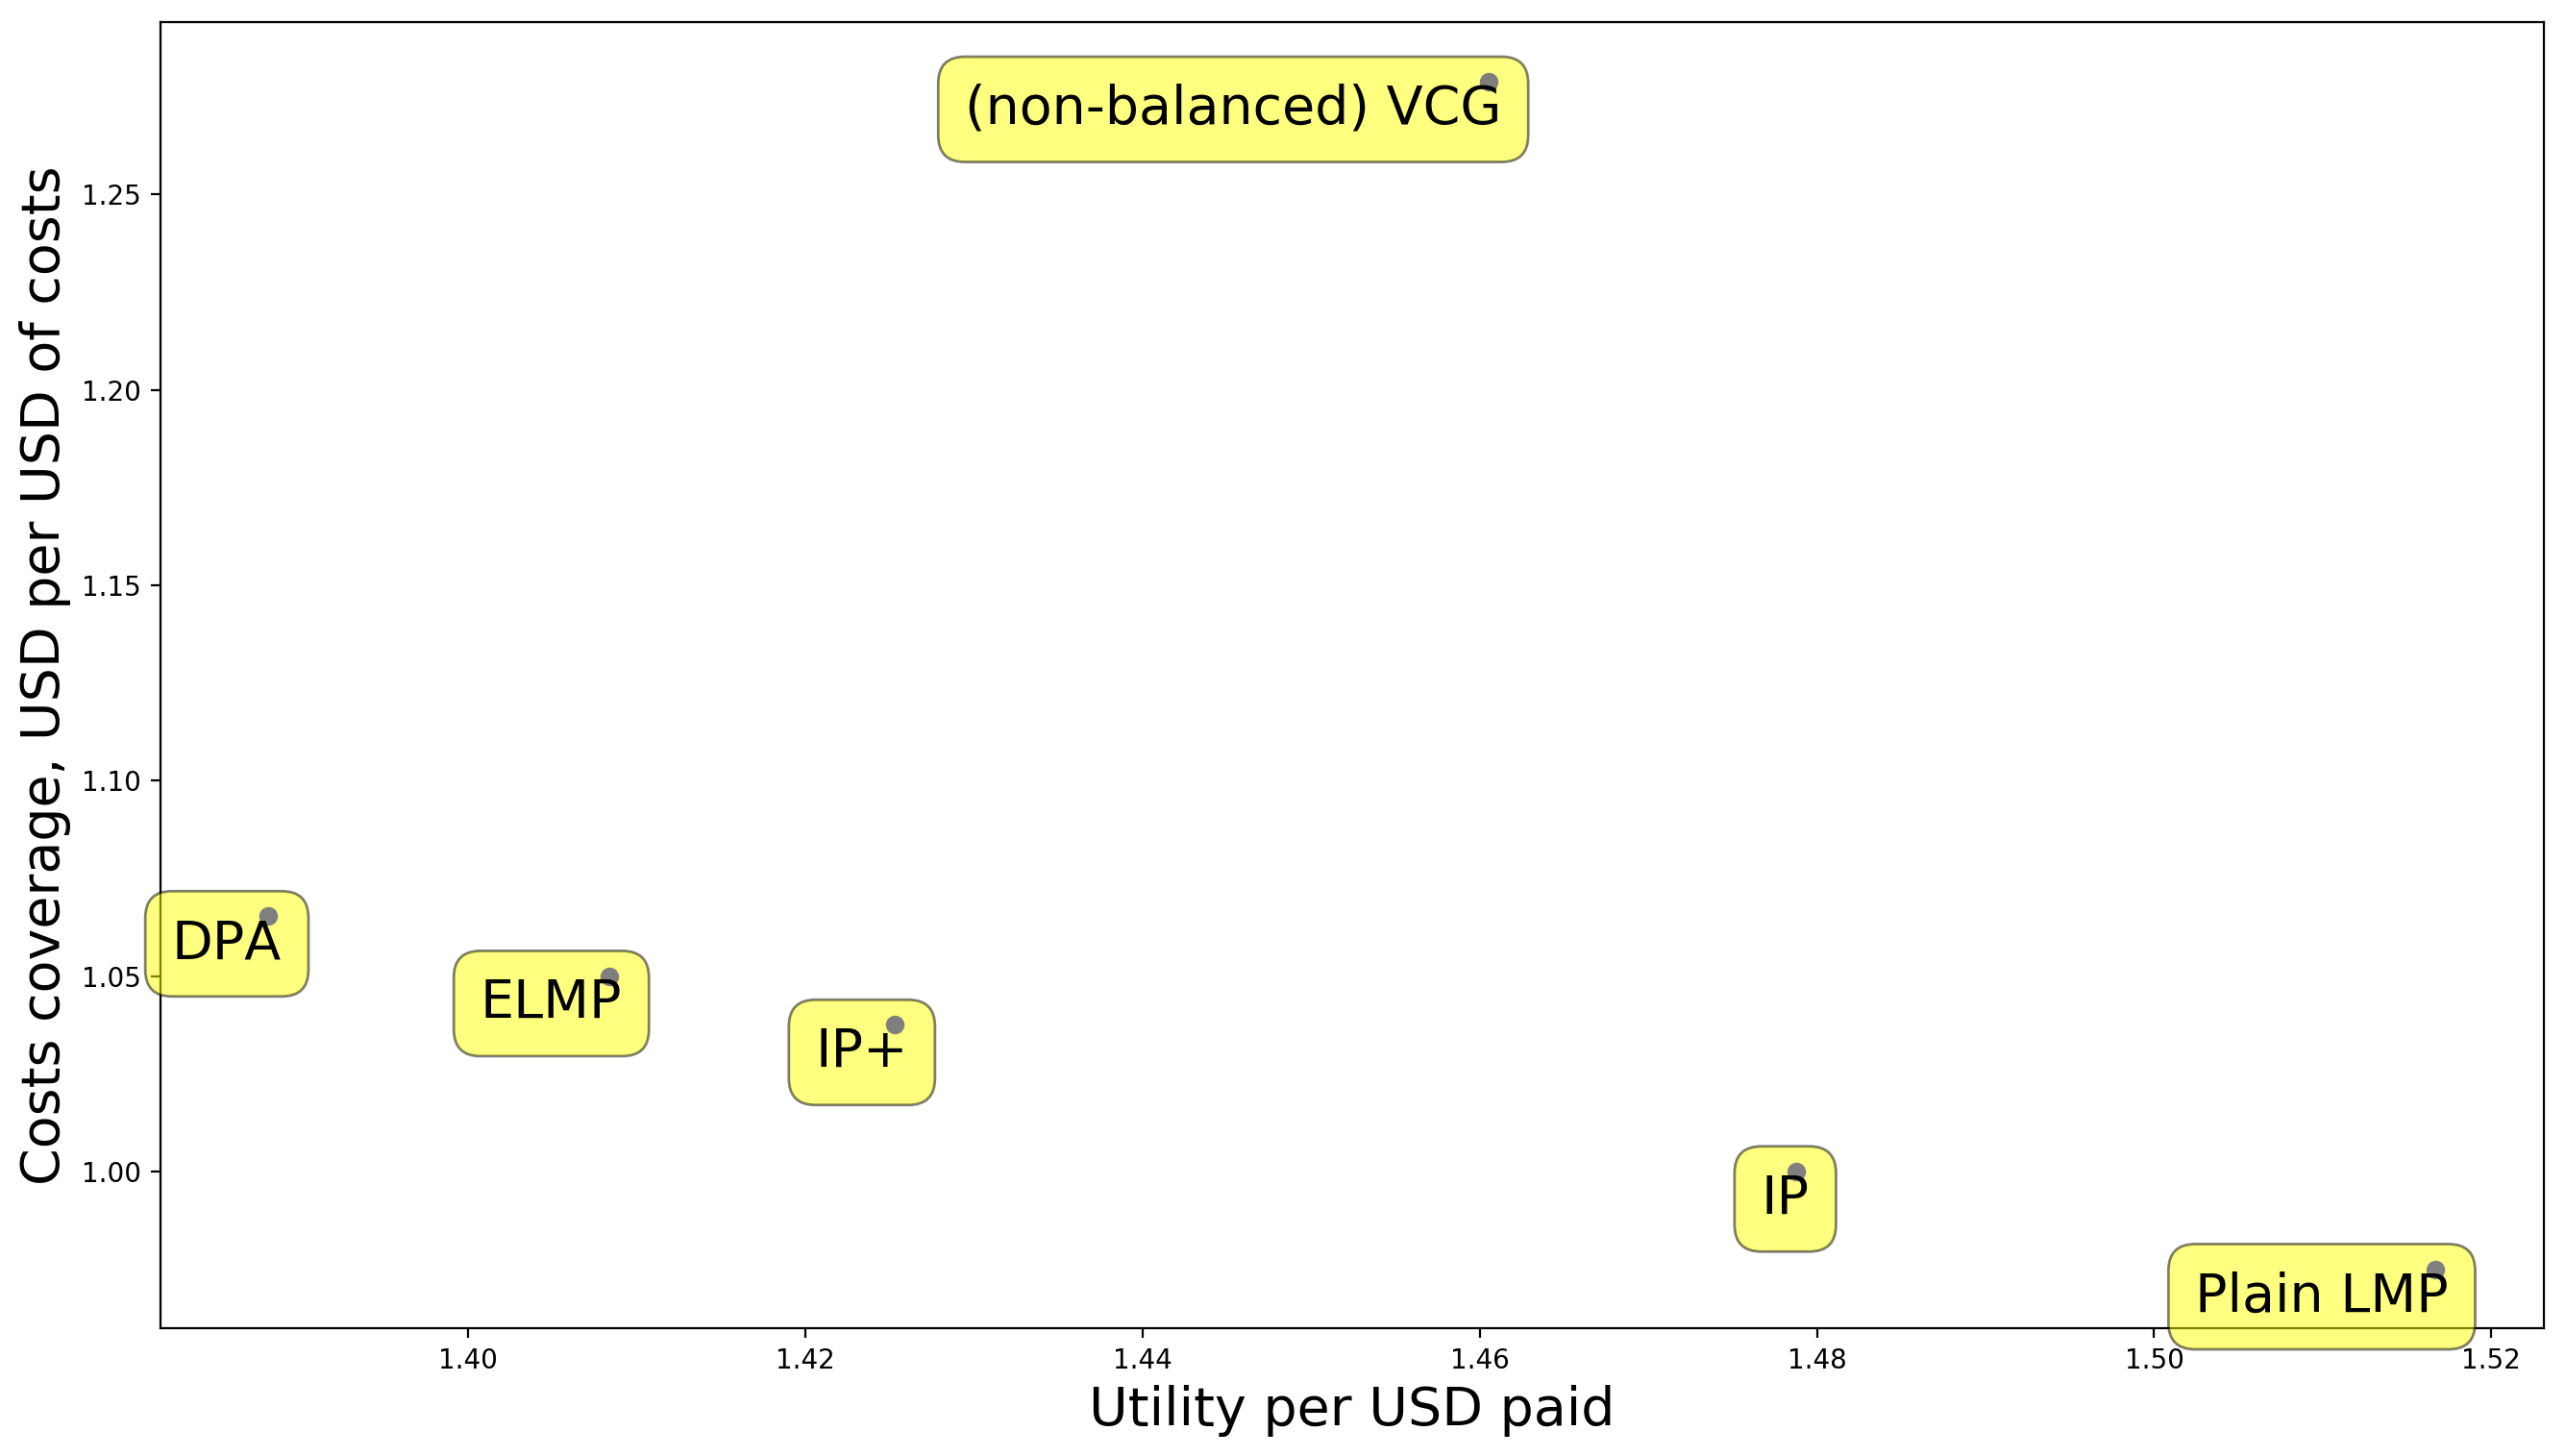

In [41]:
## Now, let us re-draw the graph:
# Figure 3b from the report
pts_x=modeling_results.UtilityGain/modeling_results.PaidByC;
pts_y=modeling_results.PaidToGen/modeling_results.Costs;

pts_x = [x for x in pts_x]
pts_y = [x for x in pts_y]

pts_x.append(UtilityGain_VCG/PaidByC_VCG); ## manually append the VCG data
pts_y.append(PaidToGen_VCG/Costs_VCG);

labels = [x for x in modeling_results.index]
labels.append("(non-balanced) VCG");

plt.figure(figsize=(16, 9), dpi= 200, facecolor='w', edgecolor='k')

for i in range(len(pts_x)):
    plt.annotate(
        labels[i],
        xy=(pts_x[i],pts_y[i]),
        xytext=(5, -20),
        size=20,
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5)
    )

plt.plot(pts_x,pts_y,'bo')

plt.xlabel("Utility per USD paid",size=20);
plt.ylabel("Costs coverage, USD per USD of costs",size=20);


## <a name="bVCG">Balanced VCG</a>: additional mechanism

Now let us balance the mechanism artificially, by changing the $h(v_{-i})$ term (see e.g. [wiki](https://en.wikipedia.org/wiki/Vickrey%E2%80%93Clarke%E2%80%93Groves_mechanism) for details)

In [42]:
## now let us re-scale to balance payments

TOTAL_GEN_PAYMENT = np.sum(Pvcg_gen);
TOTAL_CONS_PAYMENT = - TOTAL_GEN_PAYMENT;

gen_alpha = -(TOTAL_GEN_PAYMENT - np.sum(gen_others_surpluses)) / np.sum(gen_max_o_surpluses);
cons_alpha = -(TOTAL_CONS_PAYMENT - np.sum(others_surpluses)) / np.sum(max_o_surpluses);

Pvcg_gen_corr = [gen_others_surpluses[i] - gen_alpha * gen_max_o_surpluses[i] for i in G];
Pvcg_cons_corr = [others_surpluses[i] - cons_alpha * max_o_surpluses[i] for i in D];

In [43]:
## print results

print ("===========================================================")
print ("BALANCED VCG:")
print ("===========================================================")

print ("Prices for consumers: \n");
for i in D:
    print ("for",Dnames[i],":",-Pvcg_cons_corr[i] / db[i].varValue) 

print;
print ("Total payment TO consumers:", np.sum(Pvcg_cons_corr));

print ("Prices for generators: \n");
for i in G:
    print ("for", Gnames[i], Pvcg_gen_corr[i] / pb[i].varValue);
    
print ("Total payment TO generators:", np.sum(Pvcg_gen_corr));

print ("Non-balance (money left on the table):", np.sum(Pvcg_cons_corr) + np.sum(Pvcg_gen_corr));

BALANCED VCG:
Prices for consumers: 

for 1 : 63.70458015267175
for 2 : 128.65139949109414
Total payment TO consumers: -10230.0
Prices for generators: 

for A 60.0
for B 87.0
Total payment TO generators: 10230.0
Non-balance (money left on the table): 0.0


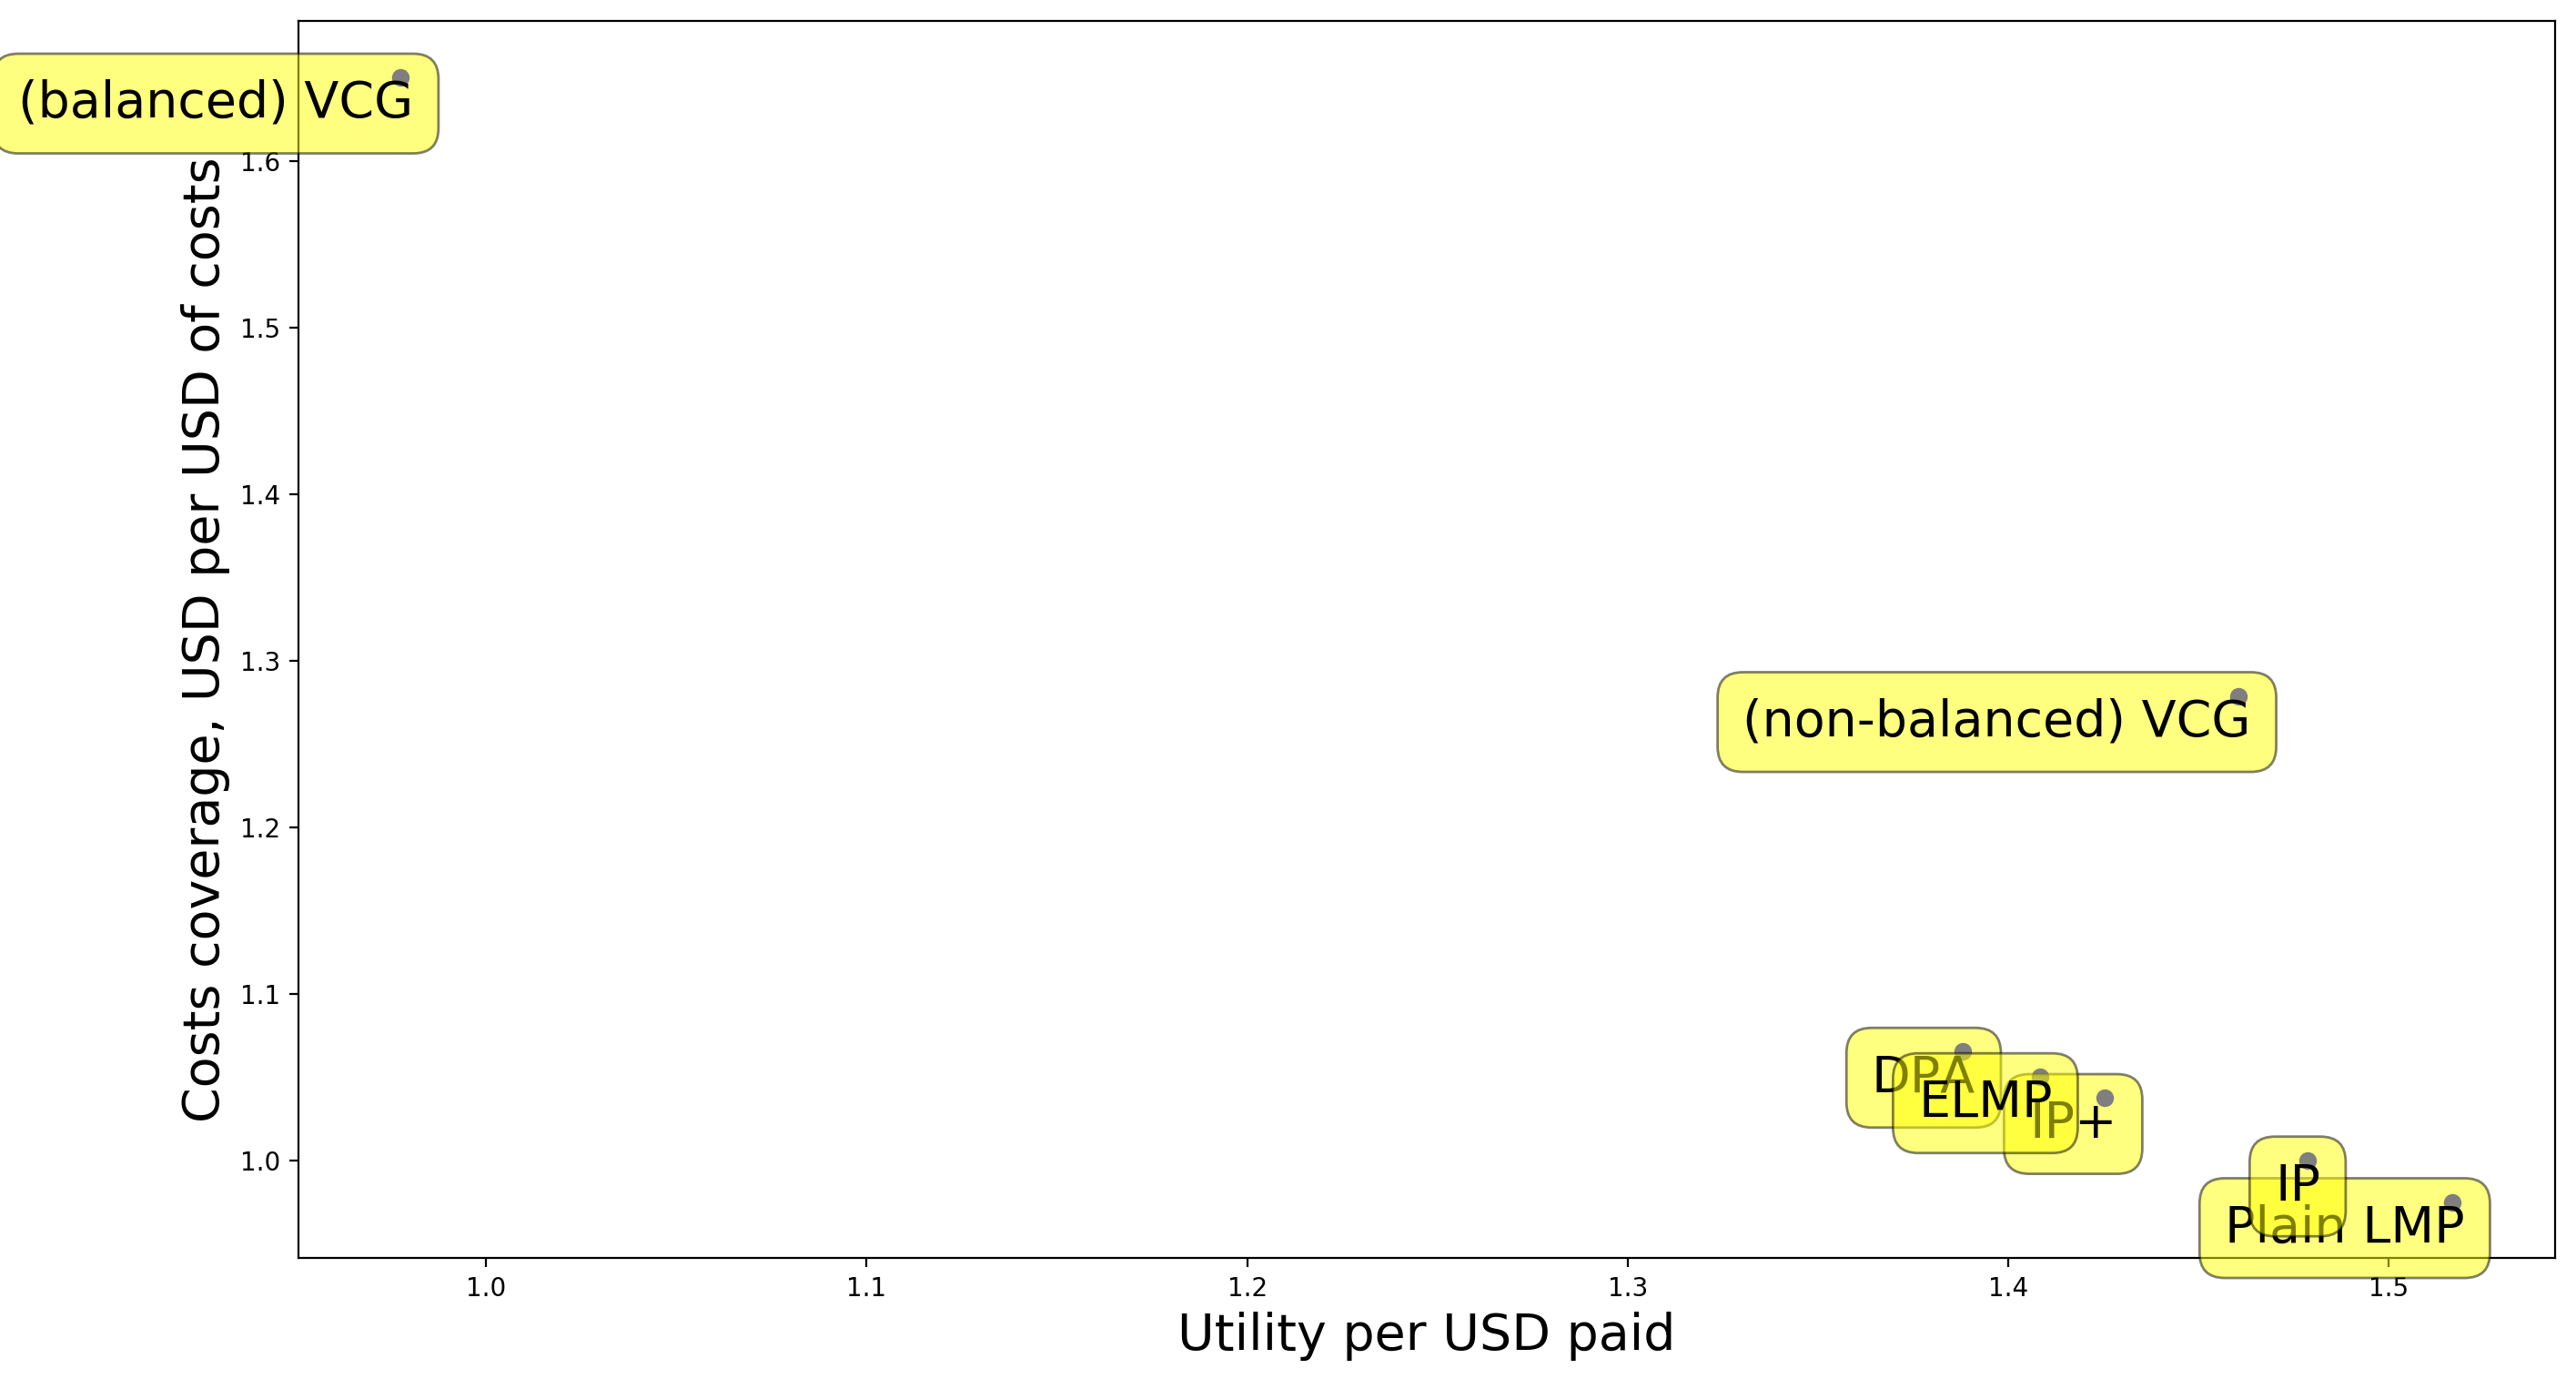

In [44]:
## Now, let us re-draw the graph again:
# not present in the report


## Calculating total payments for a balanced VCG mechanism

UtilityGain_bVCG = b[0]*d[0].varValue + b[1]*d[1].varValue
PaidByC_bVCG = -np.sum(Pvcg_cons_corr);

PaidToGen_bVCG = --np.sum(Pvcg_gen_corr);
Costs_bVCG = c[0]*p[0].varValue+cSU[0]*(p[0].varValue>0) + c[1]*p[1].varValue+cSU[1]*(p[1].varValue>0)

pts_x.append(UtilityGain_bVCG/PaidByC_bVCG); ## manually append the VCG data
pts_y.append(PaidToGen_bVCG/Costs_bVCG);

labels.append("(balanced) VCG");

plt.figure(figsize=(16, 9), dpi= 200, facecolor='w', edgecolor='k')

for i in range(len(pts_x)):
    plt.annotate(
        labels[i],
        xy=(pts_x[i],pts_y[i]),
        xytext=(5, -20),
        size=20,
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5)
    )

plt.plot(pts_x,pts_y,'bo')

plt.xlabel("Utility per USD paid",size=20);
plt.ylabel("Costs coverage, USD per USD of costs",size=20);


Note that results seem somewhat logical: balancing the mechanism that favors generation significantly -- would significantly decrease the total utility of consumers. The logic from the discussion of the non-balanced VCG in the report, probably, equally applies to that mechanism. It is worth noticing also that the total externality of all the generators on the system -- is, obviously, all the consumers' surplus (i.e. removing all the generators will render market surplus zero).